# This is a tutorial of using spaVAE for enhancing spatial resolutions of mouse olfactory bulb data

This tutorial was implemented on Macbook Pro M1.

Import modules.

In [1]:
import math, os
from time import time

import torch
from spaVAE import SPAVAE
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import h5py
import scanpy as sc
from preprocess import normalize, geneSelection

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup parameters.

In [2]:
'''
Parameter setting
'''

class Args(object):
    def __init__(self):
        self.data_file = 'Rep9_MOB.h5'
        self.select_genes = 0
        self.batch_size = 512
        self.maxiter = 2000
        self.lr = 1e-3
        self.weight_decay = 1e-2
        self.noise = 0
        self.dropoutE = 0
        self.dropoutD = 0
        self.encoder_layers = [128, 64, 32]
        self.z_dim = 2
        self.decoder_layers = [32]
        self.beta = 20
        self.num_samples = 1
        self.fix_inducing_points = True
        self.grid_inducing_points = True
        self.inducing_point_steps = 6
        self.inducing_point_nums = None
        self.fixed_gp_params = False
        self.kernel_scale = 20.
        self.model_file = "model.pt"
        self.final_latent_file = "final_latent.txt"
        self.denoised_counts_file = "denoised_counts.txt"
        self.enhanced_counts_file = 'enhanced_counts.txt'
        self.device = "cpu"

args = Args()

Setup inducing points, preprocess count matrix, and build the spaVAE model.

In [3]:
print(args)

data_mat = h5py.File(args.data_file, 'r')
x = np.array(data_mat['X']).astype('float64') # count matrix
loc = np.array(data_mat['pos']).astype('float64') # location information
data_mat.close()

if args.select_genes > 0:
    importantGenes = geneSelection(x, n=args.select_genes, plot=False)
    x = x[:, importantGenes]
    np.savetxt("selected_genes.txt", importantGenes, delimiter=",", fmt="%i")

scaler = MinMaxScaler()
loc = scaler.fit_transform(loc) * 20.

print(x.shape)
print(loc.shape)

eps = 1e-5
initial_inducing_points = np.mgrid[0:(1+eps):(1./args.inducing_point_steps), 0:(1+eps):(1./args.inducing_point_steps)].reshape(2, -1).T * 20.
print(initial_inducing_points.shape)

adata = sc.AnnData(x, dtype="float64")

adata = normalize(adata,
                  size_factors=True,
                  normalize_input=True,
                  logtrans_input=True)

model = SPAVAE(input_dim=adata.n_vars, z_dim=args.z_dim, encoder_layers=args.encoder_layers, decoder_layers=args.decoder_layers,
    noise=args.noise, encoder_dropout=args.dropoutE, decoder_dropout=args.dropoutD,
    fixed_inducing_points=args.fix_inducing_points, initial_inducing_points=initial_inducing_points, 
    fixed_gp_params=args.fixed_gp_params, kernel_scale=args.kernel_scale, N_train=adata.n_obs, beta=args.beta, dtype=torch.float64, 
    device=args.device)

print(str(model))

(236, 2949)
(236, 2)
(49, 2)
SPAVAE(
  (svgp): SVGP(
    (kernel): CauchyKernel()
  )
  (encoder): DenseEncoder(
    (layers): Sequential(
      (0): Linear(in_features=2949, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=64, out_features=32, bias=True)
      (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ELU(alpha=1.0)
    )
    (enc_mu): Linear(in_features=32, out_features=2, bias=True)
    (enc_var): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2)

Train the model.

In [4]:
t0 = time()

model.train_model(pos=loc, ncounts=adata.X, raw_counts=adata.raw.X, size_factors=adata.obs.size_factors,
            lr=args.lr, weight_decay=args.weight_decay, batch_size=args.batch_size, num_samples=args.num_samples,
            maxiter=args.maxiter, save_model=True, model_weights=args.model_file)
print('Training time: %d seconds.' % int(time() - t0))

final_latent = model.batching_latent_samples(X=loc, Y=adata.X, batch_size=args.batch_size)
np.savetxt(args.final_latent_file, final_latent, delimiter=",")


denoised_counts = model.batching_denoise_counts(X=loc, Y=adata.X, batch_size=args.batch_size, n_samples=25)
np.savetxt(args.denoised_counts_file, denoised_counts, delimiter=",")

Training
Training epoch 1, ELBO:36.45768475, NB loss:1.81980731, KLD loss:0.06153863, noise regularization:0.000000
Current kernel scale tensor([20.0008])
Training epoch 2, ELBO:36.38423102, NB loss:1.81379919, KLD loss:0.10824728, noise regularization:0.000000
Current kernel scale tensor([20.0016])
Training epoch 3, ELBO:36.18252757, NB loss:1.80460418, KLD loss:0.09044404, noise regularization:0.000000
Current kernel scale tensor([20.0023])
Training epoch 4, ELBO:36.05827698, NB loss:1.79860519, KLD loss:0.08617324, noise regularization:0.000000
Current kernel scale tensor([20.0031])
Training epoch 5, ELBO:35.98232542, NB loss:1.79464755, KLD loss:0.08937436, noise regularization:0.000000
Current kernel scale tensor([20.0039])
Training epoch 6, ELBO:35.85046047, NB loss:1.78771947, KLD loss:0.09607103, noise regularization:0.000000
Current kernel scale tensor([20.0047])
Training epoch 7, ELBO:35.74814141, NB loss:1.78225384, KLD loss:0.10306462, noise regularization:0.000000
Current 

Training epoch 59, ELBO:31.75487825, NB loss:1.57888925, KLD loss:0.17709315, noise regularization:0.000000
Current kernel scale tensor([20.0516])
Training epoch 60, ELBO:31.69601785, NB loss:1.57587844, KLD loss:0.17844900, noise regularization:0.000000
Current kernel scale tensor([20.0527])
Training epoch 61, ELBO:31.63512590, NB loss:1.57272012, KLD loss:0.18072360, noise regularization:0.000000
Current kernel scale tensor([20.0537])
Training epoch 62, ELBO:31.57743119, NB loss:1.56972914, KLD loss:0.18284842, noise regularization:0.000000
Current kernel scale tensor([20.0548])
Training epoch 63, ELBO:31.46419908, NB loss:1.56397017, KLD loss:0.18479569, noise regularization:0.000000
Current kernel scale tensor([20.0559])
Training epoch 64, ELBO:31.43885070, NB loss:1.56261963, KLD loss:0.18645807, noise regularization:0.000000
Current kernel scale tensor([20.0570])
Training epoch 65, ELBO:31.38577892, NB loss:1.55991894, KLD loss:0.18740014, noise regularization:0.000000
Current ke

Training epoch 118, ELBO:28.38846634, NB loss:1.40941438, KLD loss:0.20017875, noise regularization:0.000000
Current kernel scale tensor([20.1113])
Training epoch 119, ELBO:28.29466755, NB loss:1.40478409, KLD loss:0.19898567, noise regularization:0.000000
Current kernel scale tensor([20.1124])
Training epoch 120, ELBO:28.30280304, NB loss:1.40525348, KLD loss:0.19773350, noise regularization:0.000000
Current kernel scale tensor([20.1134])
Training epoch 121, ELBO:28.22397480, NB loss:1.40127825, KLD loss:0.19840972, noise regularization:0.000000
Current kernel scale tensor([20.1144])
Training epoch 122, ELBO:28.21199995, NB loss:1.40057947, KLD loss:0.20041063, noise regularization:0.000000
Current kernel scale tensor([20.1155])
Training epoch 123, ELBO:28.15001624, NB loss:1.39730323, KLD loss:0.20395157, noise regularization:0.000000
Current kernel scale tensor([20.1165])
Training epoch 124, ELBO:28.13780116, NB loss:1.39649364, KLD loss:0.20792843, noise regularization:0.000000
Cur

Training epoch 174, ELBO:26.86274156, NB loss:1.33270585, KLD loss:0.20862450, noise regularization:0.000000
Current kernel scale tensor([20.1711])
Training epoch 175, ELBO:26.87683023, NB loss:1.33335565, KLD loss:0.20971724, noise regularization:0.000000
Current kernel scale tensor([20.1723])
Training epoch 176, ELBO:26.83945026, NB loss:1.33145486, KLD loss:0.21035299, noise regularization:0.000000
Current kernel scale tensor([20.1734])
Training epoch 177, ELBO:26.82480475, NB loss:1.33074284, KLD loss:0.20994794, noise regularization:0.000000
Current kernel scale tensor([20.1746])
Training epoch 178, ELBO:26.79561094, NB loss:1.32930535, KLD loss:0.20950390, noise regularization:0.000000
Current kernel scale tensor([20.1757])
Training epoch 179, ELBO:26.81372610, NB loss:1.33023388, KLD loss:0.20904859, noise regularization:0.000000
Current kernel scale tensor([20.1769])
Training epoch 180, ELBO:26.75715971, NB loss:1.32736355, KLD loss:0.20988869, noise regularization:0.000000
Cur

Training epoch 231, ELBO:26.34184035, NB loss:1.30674620, KLD loss:0.20691631, noise regularization:0.000000
Current kernel scale tensor([20.2322])
Training epoch 232, ELBO:26.37766103, NB loss:1.30852842, KLD loss:0.20709265, noise regularization:0.000000
Current kernel scale tensor([20.2333])
Training epoch 233, ELBO:26.35134313, NB loss:1.30714852, KLD loss:0.20837277, noise regularization:0.000000
Current kernel scale tensor([20.2344])
Training epoch 234, ELBO:26.35172340, NB loss:1.30710835, KLD loss:0.20955639, noise regularization:0.000000
Current kernel scale tensor([20.2355])
Training epoch 235, ELBO:26.34327743, NB loss:1.30663628, KLD loss:0.21055183, noise regularization:0.000000
Current kernel scale tensor([20.2366])
Training epoch 236, ELBO:26.30659758, NB loss:1.30473875, KLD loss:0.21182267, noise regularization:0.000000
Current kernel scale tensor([20.2378])
Training epoch 237, ELBO:26.32801830, NB loss:1.30577229, KLD loss:0.21257247, noise regularization:0.000000
Cur

Training epoch 287, ELBO:26.10519219, NB loss:1.29498289, KLD loss:0.20553439, noise regularization:0.000000
Current kernel scale tensor([20.2888])
Training epoch 288, ELBO:26.14086374, NB loss:1.29670244, KLD loss:0.20681500, noise regularization:0.000000
Current kernel scale tensor([20.2898])
Training epoch 289, ELBO:26.12676037, NB loss:1.29592502, KLD loss:0.20825995, noise regularization:0.000000
Current kernel scale tensor([20.2908])
Training epoch 290, ELBO:26.11984992, NB loss:1.29554385, KLD loss:0.20897286, noise regularization:0.000000
Current kernel scale tensor([20.2918])
Training epoch 291, ELBO:26.08140713, NB loss:1.29361921, KLD loss:0.20902299, noise regularization:0.000000
Current kernel scale tensor([20.2928])
Training epoch 292, ELBO:26.09202354, NB loss:1.29416794, KLD loss:0.20866470, noise regularization:0.000000
Current kernel scale tensor([20.2937])
Training epoch 293, ELBO:26.09287617, NB loss:1.29423063, KLD loss:0.20826365, noise regularization:0.000000
Cur

Training epoch 343, ELBO:25.94815386, NB loss:1.28683866, KLD loss:0.21138072, noise regularization:0.000000
Current kernel scale tensor([20.3415])
Training epoch 344, ELBO:25.97058766, NB loss:1.28801225, KLD loss:0.21034262, noise regularization:0.000000
Current kernel scale tensor([20.3425])
Training epoch 345, ELBO:25.96292487, NB loss:1.28767394, KLD loss:0.20944599, noise regularization:0.000000
Current kernel scale tensor([20.3434])
Training epoch 346, ELBO:25.97196702, NB loss:1.28812920, KLD loss:0.20938307, noise regularization:0.000000
Current kernel scale tensor([20.3443])
Training epoch 347, ELBO:25.95674425, NB loss:1.28737755, KLD loss:0.20919316, noise regularization:0.000000
Current kernel scale tensor([20.3452])
Training epoch 348, ELBO:25.98680197, NB loss:1.28886275, KLD loss:0.20954706, noise regularization:0.000000
Current kernel scale tensor([20.3462])
Training epoch 349, ELBO:25.94380876, NB loss:1.28663607, KLD loss:0.21108734, noise regularization:0.000000
Cur

Training epoch 401, ELBO:25.81496840, NB loss:1.28046102, KLD loss:0.20574808, noise regularization:0.000000
Current kernel scale tensor([20.3933])
Training epoch 402, ELBO:25.84072540, NB loss:1.28171975, KLD loss:0.20633040, noise regularization:0.000000
Current kernel scale tensor([20.3941])
Training epoch 403, ELBO:25.80426369, NB loss:1.27985802, KLD loss:0.20710322, noise regularization:0.000000
Current kernel scale tensor([20.3950])
Training epoch 404, ELBO:25.79978594, NB loss:1.27962335, KLD loss:0.20731899, noise regularization:0.000000
Current kernel scale tensor([20.3958])
Training epoch 405, ELBO:25.81926268, NB loss:1.28059288, KLD loss:0.20740505, noise regularization:0.000000
Current kernel scale tensor([20.3967])
Training epoch 406, ELBO:25.83547740, NB loss:1.28138759, KLD loss:0.20772568, noise regularization:0.000000
Current kernel scale tensor([20.3975])
Training epoch 407, ELBO:25.83367068, NB loss:1.28126532, KLD loss:0.20836437, noise regularization:0.000000
Cur

Training epoch 458, ELBO:25.72226816, NB loss:1.27526630, KLD loss:0.21694212, noise regularization:0.000000
Current kernel scale tensor([20.4432])
Training epoch 459, ELBO:25.69970654, NB loss:1.27417275, KLD loss:0.21625160, noise regularization:0.000000
Current kernel scale tensor([20.4441])
Training epoch 460, ELBO:25.76071510, NB loss:1.27728148, KLD loss:0.21508560, noise regularization:0.000000
Current kernel scale tensor([20.4450])
Training epoch 461, ELBO:25.72189182, NB loss:1.27534312, KLD loss:0.21502950, noise regularization:0.000000
Current kernel scale tensor([20.4459])
Training epoch 462, ELBO:25.69189102, NB loss:1.27381962, KLD loss:0.21549863, noise regularization:0.000000
Current kernel scale tensor([20.4467])
Training epoch 463, ELBO:25.68918330, NB loss:1.27364801, KLD loss:0.21622301, noise regularization:0.000000
Current kernel scale tensor([20.4476])
Training epoch 464, ELBO:25.70788710, NB loss:1.27456822, KLD loss:0.21652263, noise regularization:0.000000
Cur

Training epoch 516, ELBO:25.59724930, NB loss:1.26906954, KLD loss:0.21585859, noise regularization:0.000000
Current kernel scale tensor([20.4928])
Training epoch 517, ELBO:25.58559619, NB loss:1.26852321, KLD loss:0.21513207, noise regularization:0.000000
Current kernel scale tensor([20.4936])
Training epoch 518, ELBO:25.60396666, NB loss:1.26950856, KLD loss:0.21379543, noise regularization:0.000000
Current kernel scale tensor([20.4944])
Training epoch 519, ELBO:25.62563138, NB loss:1.27065700, KLD loss:0.21249139, noise regularization:0.000000
Current kernel scale tensor([20.4952])
Training epoch 520, ELBO:25.61866790, NB loss:1.27034994, KLD loss:0.21166916, noise regularization:0.000000
Current kernel scale tensor([20.4961])
Training epoch 521, ELBO:25.60192295, NB loss:1.26952563, KLD loss:0.21141040, noise regularization:0.000000
Current kernel scale tensor([20.4969])
Training epoch 522, ELBO:25.59790832, NB loss:1.26931931, KLD loss:0.21152209, noise regularization:0.000000
Cur

Training epoch 572, ELBO:25.50440923, NB loss:1.26460023, KLD loss:0.21240463, noise regularization:0.000000
Current kernel scale tensor([20.5399])
Training epoch 573, ELBO:25.51562712, NB loss:1.26518428, KLD loss:0.21194151, noise regularization:0.000000
Current kernel scale tensor([20.5407])
Training epoch 574, ELBO:25.51672822, NB loss:1.26526968, KLD loss:0.21133457, noise regularization:0.000000
Current kernel scale tensor([20.5416])
Training epoch 575, ELBO:25.50030371, NB loss:1.26447919, KLD loss:0.21071983, noise regularization:0.000000
Current kernel scale tensor([20.5424])
Training epoch 576, ELBO:25.50192184, NB loss:1.26459673, KLD loss:0.20998717, noise regularization:0.000000
Current kernel scale tensor([20.5433])
Training epoch 577, ELBO:25.51514251, NB loss:1.26531235, KLD loss:0.20889549, noise regularization:0.000000
Current kernel scale tensor([20.5441])
Training epoch 578, ELBO:25.50459411, NB loss:1.26480266, KLD loss:0.20854097, noise regularization:0.000000
Cur

Training epoch 631, ELBO:25.42969023, NB loss:1.26090253, KLD loss:0.21163954, noise regularization:0.000000
Current kernel scale tensor([20.5883])
Training epoch 632, ELBO:25.45901498, NB loss:1.26237644, KLD loss:0.21148621, noise regularization:0.000000
Current kernel scale tensor([20.5892])
Training epoch 633, ELBO:25.45116554, NB loss:1.26195729, KLD loss:0.21201982, noise regularization:0.000000
Current kernel scale tensor([20.5900])
Training epoch 634, ELBO:25.41475337, NB loss:1.26007562, KLD loss:0.21324107, noise regularization:0.000000
Current kernel scale tensor([20.5909])
Training epoch 635, ELBO:25.43472333, NB loss:1.26102576, KLD loss:0.21420818, noise regularization:0.000000
Current kernel scale tensor([20.5917])
Training epoch 636, ELBO:25.41525005, NB loss:1.26000819, KLD loss:0.21508629, noise regularization:0.000000
Current kernel scale tensor([20.5926])
Training epoch 637, ELBO:25.40727742, NB loss:1.25957773, KLD loss:0.21572275, noise regularization:0.000000
Cur

Training epoch 690, ELBO:25.33471991, NB loss:1.25623204, KLD loss:0.21007915, noise regularization:0.000000
Current kernel scale tensor([20.6357])
Training epoch 691, ELBO:25.32653961, NB loss:1.25580913, KLD loss:0.21035709, noise regularization:0.000000
Current kernel scale tensor([20.6365])
Training epoch 692, ELBO:25.34140289, NB loss:1.25653518, KLD loss:0.21069936, noise regularization:0.000000
Current kernel scale tensor([20.6373])
Training epoch 693, ELBO:25.33116869, NB loss:1.25599260, KLD loss:0.21131668, noise regularization:0.000000
Current kernel scale tensor([20.6381])
Training epoch 694, ELBO:25.35479481, NB loss:1.25714245, KLD loss:0.21194574, noise regularization:0.000000
Current kernel scale tensor([20.6389])
Training epoch 695, ELBO:25.35430000, NB loss:1.25708264, KLD loss:0.21264723, noise regularization:0.000000
Current kernel scale tensor([20.6397])
Training epoch 696, ELBO:25.35819428, NB loss:1.25724299, KLD loss:0.21333453, noise regularization:0.000000
Cur

Training epoch 746, ELBO:25.28467296, NB loss:1.25350102, KLD loss:0.21465249, noise regularization:0.000000
Current kernel scale tensor([20.6803])
Training epoch 747, ELBO:25.26279920, NB loss:1.25235724, KLD loss:0.21565431, noise regularization:0.000000
Current kernel scale tensor([20.6811])
Training epoch 748, ELBO:25.25852116, NB loss:1.25209873, KLD loss:0.21654656, noise regularization:0.000000
Current kernel scale tensor([20.6819])
Training epoch 749, ELBO:25.25210636, NB loss:1.25176620, KLD loss:0.21678229, noise regularization:0.000000
Current kernel scale tensor([20.6827])
Training epoch 750, ELBO:25.27829426, NB loss:1.25308014, KLD loss:0.21669137, noise regularization:0.000000
Current kernel scale tensor([20.6835])
Training epoch 751, ELBO:25.26655038, NB loss:1.25249639, KLD loss:0.21662260, noise regularization:0.000000
Current kernel scale tensor([20.6843])
Training epoch 752, ELBO:25.24371730, NB loss:1.25133191, KLD loss:0.21707906, noise regularization:0.000000
Cur

Training epoch 802, ELBO:25.18622974, NB loss:1.24883057, KLD loss:0.20961844, noise regularization:0.000000
Current kernel scale tensor([20.7248])
Training epoch 803, ELBO:25.17813205, NB loss:1.24837670, KLD loss:0.21059813, noise regularization:0.000000
Current kernel scale tensor([20.7255])
Training epoch 804, ELBO:25.16169776, NB loss:1.24751288, KLD loss:0.21144025, noise regularization:0.000000
Current kernel scale tensor([20.7263])
Training epoch 805, ELBO:25.17869535, NB loss:1.24834032, KLD loss:0.21188889, noise regularization:0.000000
Current kernel scale tensor([20.7271])
Training epoch 806, ELBO:25.15765710, NB loss:1.24727797, KLD loss:0.21209774, noise regularization:0.000000
Current kernel scale tensor([20.7278])
Training epoch 807, ELBO:25.17366627, NB loss:1.24808933, KLD loss:0.21187977, noise regularization:0.000000
Current kernel scale tensor([20.7286])
Training epoch 808, ELBO:25.17509309, NB loss:1.24816698, KLD loss:0.21175345, noise regularization:0.000000
Cur

Training epoch 859, ELBO:25.11202929, NB loss:1.24493425, KLD loss:0.21334434, noise regularization:0.000000
Current kernel scale tensor([20.7686])
Training epoch 860, ELBO:25.08041148, NB loss:1.24334752, KLD loss:0.21346110, noise regularization:0.000000
Current kernel scale tensor([20.7693])
Training epoch 861, ELBO:25.09561802, NB loss:1.24412600, KLD loss:0.21309798, noise regularization:0.000000
Current kernel scale tensor([20.7701])
Training epoch 862, ELBO:25.11308761, NB loss:1.24502687, KLD loss:0.21255029, noise regularization:0.000000
Current kernel scale tensor([20.7709])
Training epoch 863, ELBO:25.09406235, NB loss:1.24409524, KLD loss:0.21215758, noise regularization:0.000000
Current kernel scale tensor([20.7716])
Training epoch 864, ELBO:25.07726408, NB loss:1.24326057, KLD loss:0.21205263, noise regularization:0.000000
Current kernel scale tensor([20.7724])
Training epoch 865, ELBO:25.08775781, NB loss:1.24380433, KLD loss:0.21167112, noise regularization:0.000000
Cur

Training epoch 916, ELBO:25.05313064, NB loss:1.24222696, KLD loss:0.20859152, noise regularization:0.000000
Current kernel scale tensor([20.8124])
Training epoch 917, ELBO:25.03598118, NB loss:1.24131296, KLD loss:0.20972193, noise regularization:0.000000
Current kernel scale tensor([20.8132])
Training epoch 918, ELBO:25.04455118, NB loss:1.24168782, KLD loss:0.21079486, noise regularization:0.000000
Current kernel scale tensor([20.8140])
Training epoch 919, ELBO:25.01862047, NB loss:1.24033891, KLD loss:0.21184221, noise regularization:0.000000
Current kernel scale tensor([20.8148])
Training epoch 920, ELBO:25.02802870, NB loss:1.24075469, KLD loss:0.21293498, noise regularization:0.000000
Current kernel scale tensor([20.8156])
Training epoch 921, ELBO:25.03265981, NB loss:1.24093603, KLD loss:0.21393912, noise regularization:0.000000
Current kernel scale tensor([20.8164])
Training epoch 922, ELBO:25.05515816, NB loss:1.24201503, KLD loss:0.21485752, noise regularization:0.000000
Cur

Training epoch 972, ELBO:24.97939923, NB loss:1.23830179, KLD loss:0.21336344, noise regularization:0.000000
Current kernel scale tensor([20.8556])
Training epoch 973, ELBO:24.96036450, NB loss:1.23736406, KLD loss:0.21308329, noise regularization:0.000000
Current kernel scale tensor([20.8563])
Training epoch 974, ELBO:24.94357415, NB loss:1.23655163, KLD loss:0.21254157, noise regularization:0.000000
Current kernel scale tensor([20.8570])
Training epoch 975, ELBO:24.97233896, NB loss:1.23803589, KLD loss:0.21162122, noise regularization:0.000000
Current kernel scale tensor([20.8578])
Training epoch 976, ELBO:24.97814761, NB loss:1.23836182, KLD loss:0.21091126, noise regularization:0.000000
Current kernel scale tensor([20.8586])
Training epoch 977, ELBO:24.96135622, NB loss:1.23755017, KLD loss:0.21035278, noise regularization:0.000000
Current kernel scale tensor([20.8593])
Training epoch 978, ELBO:24.95844996, NB loss:1.23744358, KLD loss:0.20957843, noise regularization:0.000000
Cur

Training epoch 1028, ELBO:24.93458371, NB loss:1.23633202, KLD loss:0.20794329, noise regularization:0.000000
Current kernel scale tensor([20.8986])
Training epoch 1029, ELBO:24.88888020, NB loss:1.23407332, KLD loss:0.20741382, noise regularization:0.000000
Current kernel scale tensor([20.8994])
Training epoch 1030, ELBO:24.88964671, NB loss:1.23414599, KLD loss:0.20672700, noise regularization:0.000000
Current kernel scale tensor([20.9001])
Training epoch 1031, ELBO:24.91234961, NB loss:1.23531432, KLD loss:0.20606324, noise regularization:0.000000
Current kernel scale tensor([20.9009])
Training epoch 1032, ELBO:24.92661971, NB loss:1.23606391, KLD loss:0.20534161, noise regularization:0.000000
Current kernel scale tensor([20.9017])
Training epoch 1033, ELBO:24.89413188, NB loss:1.23445036, KLD loss:0.20512477, noise regularization:0.000000
Current kernel scale tensor([20.9024])
Training epoch 1034, ELBO:24.89121739, NB loss:1.23429975, KLD loss:0.20522235, noise regularization:0.000

Training epoch 1086, ELBO:24.83536597, NB loss:1.23118541, KLD loss:0.21165771, noise regularization:0.000000
Current kernel scale tensor([20.9429])
Training epoch 1087, ELBO:24.85052984, NB loss:1.23191898, KLD loss:0.21215031, noise regularization:0.000000
Current kernel scale tensor([20.9437])
Training epoch 1088, ELBO:24.82263889, NB loss:1.23048708, KLD loss:0.21289735, noise regularization:0.000000
Current kernel scale tensor([20.9445])
Training epoch 1089, ELBO:24.82668289, NB loss:1.23068052, KLD loss:0.21307240, noise regularization:0.000000
Current kernel scale tensor([20.9452])
Training epoch 1090, ELBO:24.82253733, NB loss:1.23048496, KLD loss:0.21283809, noise regularization:0.000000
Current kernel scale tensor([20.9459])
Training epoch 1091, ELBO:24.80971128, NB loss:1.22988999, KLD loss:0.21191151, noise regularization:0.000000
Current kernel scale tensor([20.9466])
Training epoch 1092, ELBO:24.83036811, NB loss:1.23099376, KLD loss:0.21049294, noise regularization:0.000

Training epoch 1141, ELBO:24.75531049, NB loss:1.22736936, KLD loss:0.20792335, noise regularization:0.000000
Current kernel scale tensor([20.9832])
Training epoch 1142, ELBO:24.80012897, NB loss:1.22968454, KLD loss:0.20643823, noise regularization:0.000000
Current kernel scale tensor([20.9840])
Training epoch 1143, ELBO:24.77904674, NB loss:1.22866742, KLD loss:0.20569828, noise regularization:0.000000
Current kernel scale tensor([20.9847])
Training epoch 1144, ELBO:24.77992875, NB loss:1.22875347, KLD loss:0.20485943, noise regularization:0.000000
Current kernel scale tensor([20.9854])
Training epoch 1145, ELBO:24.77592493, NB loss:1.22859705, KLD loss:0.20398398, noise regularization:0.000000
Current kernel scale tensor([20.9861])
Training epoch 1146, ELBO:24.79824488, NB loss:1.22974792, KLD loss:0.20328657, noise regularization:0.000000
Current kernel scale tensor([20.9869])
Training epoch 1147, ELBO:24.78643603, NB loss:1.22916612, KLD loss:0.20311360, noise regularization:0.000

Training epoch 1199, ELBO:24.71218940, NB loss:1.22531898, KLD loss:0.20580987, noise regularization:0.000000
Current kernel scale tensor([21.0255])
Training epoch 1200, ELBO:24.72317908, NB loss:1.22592908, KLD loss:0.20459756, noise regularization:0.000000
Current kernel scale tensor([21.0262])
Training epoch 1201, ELBO:24.70596806, NB loss:1.22513132, KLD loss:0.20334167, noise regularization:0.000000
Current kernel scale tensor([21.0269])
Training epoch 1202, ELBO:24.73542190, NB loss:1.22667008, KLD loss:0.20202030, noise regularization:0.000000
Current kernel scale tensor([21.0276])
Training epoch 1203, ELBO:24.70502586, NB loss:1.22518106, KLD loss:0.20140461, noise regularization:0.000000
Current kernel scale tensor([21.0283])
Training epoch 1204, ELBO:24.70384260, NB loss:1.22515318, KLD loss:0.20077894, noise regularization:0.000000
Current kernel scale tensor([21.0290])
Training epoch 1205, ELBO:24.77108676, NB loss:1.22854317, KLD loss:0.20022339, noise regularization:0.000

Training epoch 1256, ELBO:24.67192737, NB loss:1.22367185, KLD loss:0.19849030, noise regularization:0.000000
Current kernel scale tensor([21.0666])
Training epoch 1257, ELBO:24.67200011, NB loss:1.22365115, KLD loss:0.19897718, noise regularization:0.000000
Current kernel scale tensor([21.0673])
Training epoch 1258, ELBO:24.65815500, NB loss:1.22293972, KLD loss:0.19936064, noise regularization:0.000000
Current kernel scale tensor([21.0680])
Training epoch 1259, ELBO:24.67883189, NB loss:1.22396753, KLD loss:0.19948130, noise regularization:0.000000
Current kernel scale tensor([21.0688])
Training epoch 1260, ELBO:24.65504946, NB loss:1.22276316, KLD loss:0.19978617, noise regularization:0.000000
Current kernel scale tensor([21.0695])
Training epoch 1261, ELBO:24.68203009, NB loss:1.22409424, KLD loss:0.20014537, noise regularization:0.000000
Current kernel scale tensor([21.0702])
Training epoch 1262, ELBO:24.66073546, NB loss:1.22300954, KLD loss:0.20054461, noise regularization:0.000

Training epoch 1311, ELBO:24.62129863, NB loss:1.22071407, KLD loss:0.20701732, noise regularization:0.000000
Current kernel scale tensor([21.1057])
Training epoch 1312, ELBO:24.60880393, NB loss:1.22014412, KLD loss:0.20592149, noise regularization:0.000000
Current kernel scale tensor([21.1064])
Training epoch 1313, ELBO:24.60340298, NB loss:1.21994431, KLD loss:0.20451685, noise regularization:0.000000
Current kernel scale tensor([21.1071])
Training epoch 1314, ELBO:24.62052720, NB loss:1.22087517, KLD loss:0.20302388, noise regularization:0.000000
Current kernel scale tensor([21.1078])
Training epoch 1315, ELBO:24.58737463, NB loss:1.21926966, KLD loss:0.20198143, noise regularization:0.000000
Current kernel scale tensor([21.1084])
Training epoch 1316, ELBO:24.60610660, NB loss:1.22027375, KLD loss:0.20063157, noise regularization:0.000000
Current kernel scale tensor([21.1091])
Training epoch 1317, ELBO:24.62405888, NB loss:1.22124425, KLD loss:0.19917378, noise regularization:0.000

Training epoch 1369, ELBO:24.54249098, NB loss:1.21708367, KLD loss:0.20081755, noise regularization:0.000000
Current kernel scale tensor([21.1472])
Training epoch 1370, ELBO:24.58505343, NB loss:1.21920545, KLD loss:0.20094436, noise regularization:0.000000
Current kernel scale tensor([21.1479])
Training epoch 1371, ELBO:24.54804197, NB loss:1.21732774, KLD loss:0.20148708, noise regularization:0.000000
Current kernel scale tensor([21.1486])
Training epoch 1372, ELBO:24.53629006, NB loss:1.21674401, KLD loss:0.20140992, noise regularization:0.000000
Current kernel scale tensor([21.1493])
Training epoch 1373, ELBO:24.56665895, NB loss:1.21829325, KLD loss:0.20079386, noise regularization:0.000000
Current kernel scale tensor([21.1500])
Training epoch 1374, ELBO:24.55817803, NB loss:1.21790334, KLD loss:0.20011122, noise regularization:0.000000
Current kernel scale tensor([21.1507])
Training epoch 1375, ELBO:24.53589201, NB loss:1.21684418, KLD loss:0.19900844, noise regularization:0.000

Training epoch 1425, ELBO:24.52304206, NB loss:1.21627309, KLD loss:0.19758020, noise regularization:0.000000
Current kernel scale tensor([21.1864])
Training epoch 1426, ELBO:24.48335729, NB loss:1.21425133, KLD loss:0.19833067, noise regularization:0.000000
Current kernel scale tensor([21.1871])
Training epoch 1427, ELBO:24.51579708, NB loss:1.21588217, KLD loss:0.19815363, noise regularization:0.000000
Current kernel scale tensor([21.1878])
Training epoch 1428, ELBO:24.50556873, NB loss:1.21536859, KLD loss:0.19819689, noise regularization:0.000000
Current kernel scale tensor([21.1885])
Training epoch 1429, ELBO:24.50065346, NB loss:1.21512195, KLD loss:0.19821451, noise regularization:0.000000
Current kernel scale tensor([21.1892])
Training epoch 1430, ELBO:24.52182879, NB loss:1.21619573, KLD loss:0.19791413, noise regularization:0.000000
Current kernel scale tensor([21.1898])
Training epoch 1431, ELBO:24.52521512, NB loss:1.21636994, KLD loss:0.19781640, noise regularization:0.000

Training epoch 1481, ELBO:24.50353740, NB loss:1.21517304, KLD loss:0.20007663, noise regularization:0.000000
Current kernel scale tensor([21.2257])
Training epoch 1482, ELBO:24.45891521, NB loss:1.21291981, KLD loss:0.20051897, noise regularization:0.000000
Current kernel scale tensor([21.2264])
Training epoch 1483, ELBO:24.53247355, NB loss:1.21659235, KLD loss:0.20062659, noise regularization:0.000000
Current kernel scale tensor([21.2271])
Training epoch 1484, ELBO:24.46217657, NB loss:1.21304317, KLD loss:0.20131321, noise regularization:0.000000
Current kernel scale tensor([21.2278])
Training epoch 1485, ELBO:24.49439647, NB loss:1.21462413, KLD loss:0.20191385, noise regularization:0.000000
Current kernel scale tensor([21.2286])
Training epoch 1486, ELBO:24.47901531, NB loss:1.21383132, KLD loss:0.20238887, noise regularization:0.000000
Current kernel scale tensor([21.2293])
Training epoch 1487, ELBO:24.48775518, NB loss:1.21425123, KLD loss:0.20273066, noise regularization:0.000

Training epoch 1537, ELBO:24.46915956, NB loss:1.21375724, KLD loss:0.19401478, noise regularization:0.000000
Current kernel scale tensor([21.2650])
Training epoch 1538, ELBO:24.41020867, NB loss:1.21076663, KLD loss:0.19487613, noise regularization:0.000000
Current kernel scale tensor([21.2657])
Training epoch 1539, ELBO:24.43529262, NB loss:1.21199644, KLD loss:0.19536383, noise regularization:0.000000
Current kernel scale tensor([21.2664])
Training epoch 1540, ELBO:24.40349921, NB loss:1.21037631, KLD loss:0.19597308, noise regularization:0.000000
Current kernel scale tensor([21.2672])
Training epoch 1541, ELBO:24.47224215, NB loss:1.21379829, KLD loss:0.19627628, noise regularization:0.000000
Current kernel scale tensor([21.2679])
Training epoch 1542, ELBO:24.43912818, NB loss:1.21210244, KLD loss:0.19707930, noise regularization:0.000000
Current kernel scale tensor([21.2686])
Training epoch 1543, ELBO:24.41512050, NB loss:1.21082880, KLD loss:0.19854455, noise regularization:0.000

Training epoch 1595, ELBO:24.40098874, NB loss:1.21013861, KLD loss:0.19821663, noise regularization:0.000000
Current kernel scale tensor([21.3048])
Training epoch 1596, ELBO:24.40752855, NB loss:1.21044434, KLD loss:0.19864184, noise regularization:0.000000
Current kernel scale tensor([21.3055])
Training epoch 1597, ELBO:24.41303625, NB loss:1.21072318, KLD loss:0.19857257, noise regularization:0.000000
Current kernel scale tensor([21.3062])
Training epoch 1598, ELBO:24.40840095, NB loss:1.21047224, KLD loss:0.19895612, noise regularization:0.000000
Current kernel scale tensor([21.3070])
Training epoch 1599, ELBO:24.41781066, NB loss:1.21091494, KLD loss:0.19951191, noise regularization:0.000000
Current kernel scale tensor([21.3077])
Training epoch 1600, ELBO:24.37231828, NB loss:1.20859719, KLD loss:0.20037446, noise regularization:0.000000
Current kernel scale tensor([21.3084])
Training epoch 1601, ELBO:24.38000182, NB loss:1.20897297, KLD loss:0.20054246, noise regularization:0.000

Training epoch 1650, ELBO:24.35288311, NB loss:1.20781263, KLD loss:0.19663049, noise regularization:0.000000
Current kernel scale tensor([21.3424])
Training epoch 1651, ELBO:24.34983168, NB loss:1.20767387, KLD loss:0.19635424, noise regularization:0.000000
Current kernel scale tensor([21.3431])
Training epoch 1652, ELBO:24.37987904, NB loss:1.20920685, KLD loss:0.19574206, noise regularization:0.000000
Current kernel scale tensor([21.3438])
Training epoch 1653, ELBO:24.32160508, NB loss:1.20629879, KLD loss:0.19562925, noise regularization:0.000000
Current kernel scale tensor([21.3445])
Training epoch 1654, ELBO:24.35159566, NB loss:1.20781501, KLD loss:0.19529544, noise regularization:0.000000
Current kernel scale tensor([21.3452])
Training epoch 1655, ELBO:24.33419212, NB loss:1.20696563, KLD loss:0.19487948, noise regularization:0.000000
Current kernel scale tensor([21.3458])
Training epoch 1656, ELBO:24.35159777, NB loss:1.20783353, KLD loss:0.19492725, noise regularization:0.000

Training epoch 1706, ELBO:24.29772263, NB loss:1.20526780, KLD loss:0.19236657, noise regularization:0.000000
Current kernel scale tensor([21.3806])
Training epoch 1707, ELBO:24.28688230, NB loss:1.20471752, KLD loss:0.19253185, noise regularization:0.000000
Current kernel scale tensor([21.3813])
Training epoch 1708, ELBO:24.33212576, NB loss:1.20696668, KLD loss:0.19279214, noise regularization:0.000000
Current kernel scale tensor([21.3820])
Training epoch 1709, ELBO:24.32364689, NB loss:1.20652353, KLD loss:0.19317629, noise regularization:0.000000
Current kernel scale tensor([21.3827])
Training epoch 1710, ELBO:24.34974446, NB loss:1.20779914, KLD loss:0.19376175, noise regularization:0.000000
Current kernel scale tensor([21.3834])
Training epoch 1711, ELBO:24.29740601, NB loss:1.20512899, KLD loss:0.19482613, noise regularization:0.000000
Current kernel scale tensor([21.3841])
Training epoch 1712, ELBO:24.31139544, NB loss:1.20578788, KLD loss:0.19563791, noise regularization:0.000

Training epoch 1762, ELBO:24.27554715, NB loss:1.20385684, KLD loss:0.19841044, noise regularization:0.000000
Current kernel scale tensor([21.4194])
Training epoch 1763, ELBO:24.27860985, NB loss:1.20406747, KLD loss:0.19726042, noise regularization:0.000000
Current kernel scale tensor([21.4201])
Training epoch 1764, ELBO:24.25963244, NB loss:1.20317210, KLD loss:0.19619047, noise regularization:0.000000
Current kernel scale tensor([21.4207])
Training epoch 1765, ELBO:24.27847870, NB loss:1.20418192, KLD loss:0.19484024, noise regularization:0.000000
Current kernel scale tensor([21.4214])
Training epoch 1766, ELBO:24.28387304, NB loss:1.20449404, KLD loss:0.19399220, noise regularization:0.000000
Current kernel scale tensor([21.4220])
Training epoch 1767, ELBO:24.29051384, NB loss:1.20485192, KLD loss:0.19347552, noise regularization:0.000000
Current kernel scale tensor([21.4227])
Training epoch 1768, ELBO:24.29449503, NB loss:1.20503648, KLD loss:0.19376550, noise regularization:0.000

Training epoch 1818, ELBO:24.25525637, NB loss:1.20302475, KLD loss:0.19476145, noise regularization:0.000000
Current kernel scale tensor([21.4578])
Training epoch 1819, ELBO:24.27129911, NB loss:1.20384337, KLD loss:0.19443165, noise regularization:0.000000
Current kernel scale tensor([21.4584])
Training epoch 1820, ELBO:24.24441651, NB loss:1.20251626, KLD loss:0.19409132, noise regularization:0.000000
Current kernel scale tensor([21.4591])
Training epoch 1821, ELBO:24.22243852, NB loss:1.20144326, KLD loss:0.19357330, noise regularization:0.000000
Current kernel scale tensor([21.4597])
Training epoch 1822, ELBO:24.23462434, NB loss:1.20208575, KLD loss:0.19290938, noise regularization:0.000000
Current kernel scale tensor([21.4604])
Training epoch 1823, ELBO:24.22749214, NB loss:1.20176383, KLD loss:0.19221554, noise regularization:0.000000
Current kernel scale tensor([21.4610])
Training epoch 1824, ELBO:24.23754114, NB loss:1.20227421, KLD loss:0.19205687, noise regularization:0.000

Training epoch 1874, ELBO:24.22278515, NB loss:1.20128688, KLD loss:0.19704764, noise regularization:0.000000
Current kernel scale tensor([21.4960])
Training epoch 1875, ELBO:24.24207197, NB loss:1.20223642, KLD loss:0.19734358, noise regularization:0.000000
Current kernel scale tensor([21.4967])
Training epoch 1876, ELBO:24.23190230, NB loss:1.20170931, KLD loss:0.19771606, noise regularization:0.000000
Current kernel scale tensor([21.4974])
Training epoch 1877, ELBO:24.21218394, NB loss:1.20068078, KLD loss:0.19856833, noise regularization:0.000000
Current kernel scale tensor([21.4981])
Training epoch 1878, ELBO:24.21213565, NB loss:1.20063232, KLD loss:0.19948924, noise regularization:0.000000
Current kernel scale tensor([21.4989])
Training epoch 1879, ELBO:24.18861385, NB loss:1.19940139, KLD loss:0.20058613, noise regularization:0.000000
Current kernel scale tensor([21.4996])
Training epoch 1880, ELBO:24.24157190, NB loss:1.20203538, KLD loss:0.20086435, noise regularization:0.000

Training epoch 1932, ELBO:24.19536143, NB loss:1.20003504, KLD loss:0.19466058, noise regularization:0.000000
Current kernel scale tensor([21.5354])
Training epoch 1933, ELBO:24.17965369, NB loss:1.19920823, KLD loss:0.19548908, noise regularization:0.000000
Current kernel scale tensor([21.5361])
Training epoch 1934, ELBO:24.19435580, NB loss:1.19990161, KLD loss:0.19632362, noise regularization:0.000000
Current kernel scale tensor([21.5369])
Training epoch 1935, ELBO:24.18974182, NB loss:1.19962596, KLD loss:0.19722253, noise regularization:0.000000
Current kernel scale tensor([21.5376])
Training epoch 1936, ELBO:24.18576229, NB loss:1.19938748, KLD loss:0.19801276, noise regularization:0.000000
Current kernel scale tensor([21.5383])
Training epoch 1937, ELBO:24.17681191, NB loss:1.19891142, KLD loss:0.19858354, noise regularization:0.000000
Current kernel scale tensor([21.5390])
Training epoch 1938, ELBO:24.16004102, NB loss:1.19806354, KLD loss:0.19877019, noise regularization:0.000

Training epoch 1987, ELBO:24.16124950, NB loss:1.19810297, KLD loss:0.19919005, noise regularization:0.000000
Current kernel scale tensor([21.5743])
Training epoch 1988, ELBO:24.16297156, NB loss:1.19814933, KLD loss:0.19998498, noise regularization:0.000000
Current kernel scale tensor([21.5750])
Training epoch 1989, ELBO:24.18908060, NB loss:1.19941380, KLD loss:0.20080462, noise regularization:0.000000
Current kernel scale tensor([21.5757])
Training epoch 1990, ELBO:24.18588675, NB loss:1.19924046, KLD loss:0.20107756, noise regularization:0.000000
Current kernel scale tensor([21.5764])
Training epoch 1991, ELBO:24.15490625, NB loss:1.19770068, KLD loss:0.20089260, noise regularization:0.000000
Current kernel scale tensor([21.5771])
Training epoch 1992, ELBO:24.16082053, NB loss:1.19804331, KLD loss:0.19995434, noise regularization:0.000000
Current kernel scale tensor([21.5778])
Training epoch 1993, ELBO:24.16577301, NB loss:1.19834977, KLD loss:0.19877770, noise regularization:0.000

Enhancing spatial resolutions

In [5]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2).fit(loc)
nearest_dist = neigh.kneighbors(loc, n_neighbors=2)[0]
small_distance = np.median(nearest_dist[:,1])/4
loc_new1 = np.empty_like(loc)
loc_new2 = np.empty_like(loc)
loc_new3 = np.empty_like(loc)
loc_new4 = np.empty_like(loc)
loc_new1[:] = loc
loc_new2[:] = loc
loc_new3[:] = loc
loc_new4[:] = loc
loc_new1[:,0] = loc_new1[:,0] - small_distance
loc_new1[:,1] = loc_new1[:,1] + small_distance
loc_new2[:,0] = loc_new2[:,0] + small_distance
loc_new2[:,1] = loc_new2[:,1] + small_distance
loc_new3[:,0] = loc_new3[:,0] - small_distance
loc_new3[:,1] = loc_new3[:,1] - small_distance
loc_new4[:,0] = loc_new4[:,0] + small_distance
loc_new4[:,1] = loc_new4[:,1] - small_distance
loc_enhance = np.concatenate((loc_new1, loc_new2, loc_new3, loc_new4, loc), axis=0)

_, enhanced_counts = model.batching_predict_samples(X_test=loc_enhance, X_train=loc, Y_train=adata.X, batch_size=args.batch_size, n_samples=25)
np.savetxt(args.data_file[:-3]+"_"+args.enhanced_counts_file, enhanced_counts, delimiter=",")
np.savetxt(args.data_file[:-3]+"_enhanced_loc.txt", loc_enhance, delimiter=",")

Plot enhanced counts in R and ggplot2.

In [1]:
rm(list=ls())
library(rhdf5)
library(ggplot2)
library(scater)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

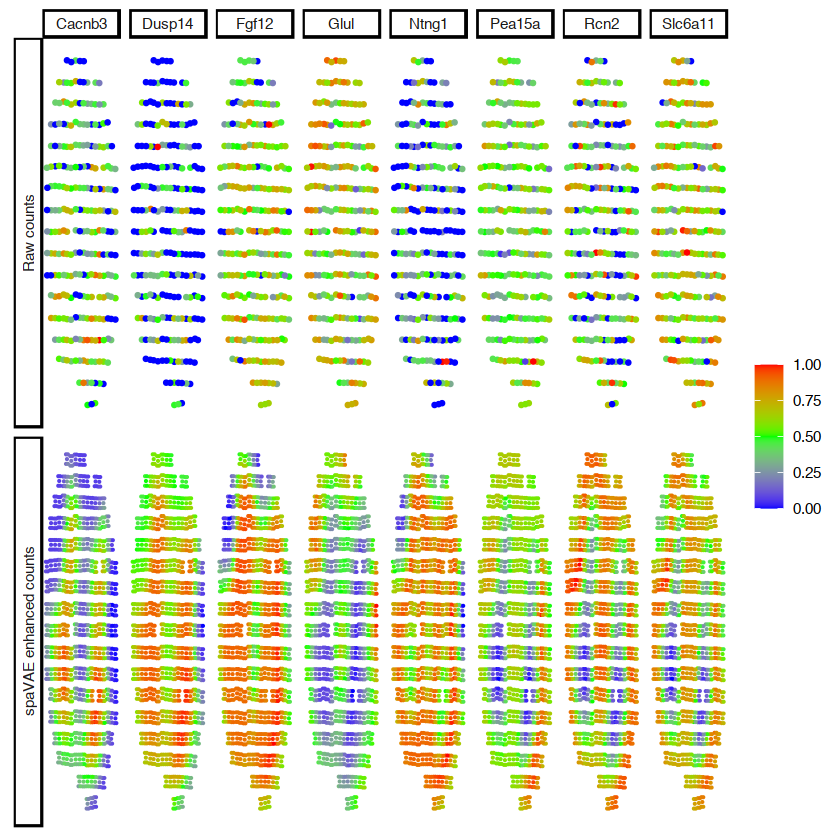

In [2]:
denoise.counts <- read.table("Rep9_MOB_enhanced_counts.txt", sep=",")
genename <- h5read("Rep9_MOB.h5", "gene")
colnames(denoise.counts) <- genename

log.denoise.counts <- log(denoise.counts)
log.denoise.counts <- apply(log.denoise.counts, 2, function(z) scales::rescale(z, to=c(0,1)))

pos <- read.table("Rep9_MOB_enhanced_loc.txt", sep=",")

enhanced.dat <- data.frame(exp=c(log.denoise.counts[, "Cacnb3"], log.denoise.counts[, "Dusp14"], 
                               log.denoise.counts[, "Glul"], log.denoise.counts[, "Rcn2"],
                               log.denoise.counts[, "Ntng1"], log.denoise.counts[, "Pea15a"],
                               log.denoise.counts[, "Fgf12"], log.denoise.counts[, "Slc6a11"]),
                         gene=rep(c("Cacnb3", "Dusp14", "Glul", "Rcn2", "Ntng1", "Pea15a", "Fgf12", "Slc6a11"), each=nrow(pos)),
                         x=rep(pos[,1], 8), y=rep(pos[,2], 8), data="spaVAE enhanced counts")

origin.pos <- t(h5read("Rep9_MOB.h5", "pos"))
origin_pos_x <- scales::rescale(origin.pos[,1], to=c(0,1))*20
origin_pos_y <- scales::rescale(origin.pos[,2], to=c(0,1))*20
origin.pos <- data.frame(V1=origin_pos_x, V2=origin_pos_y)
raw.counts <- h5read("Rep9_MOB.h5", "X")
sce <- SingleCellExperiment(list(counts=as.matrix(raw.counts)))
rownames(sce) <- genename
sce <- logNormCounts(sce, size.factors = sizeFactors(sce))
lograwcounts <- sce@assays@data$logcounts
lograwcounts <- apply(lograwcounts, 1, function(z) scales::rescale(z, to=c(0,1)))

origin.dat <- data.frame(exp=c(lograwcounts[, "Cacnb3"], lograwcounts[, "Dusp14"], 
                             lograwcounts[, "Glul"], lograwcounts[, "Rcn2"],
                             lograwcounts[, "Ntng1"], lograwcounts[, "Pea15a"],
                             lograwcounts[, "Fgf12"], lograwcounts[, "Slc6a11"]),
                       gene=rep(c("Cacnb3", "Dusp14", "Glul", "Rcn2", "Ntng1", "Pea15a", "Fgf12", "Slc6a11"), each=nrow(origin.pos)),
                       x=rep(origin.pos[,1], 8), y=rep(origin.pos[,2], 8), data="Raw counts")

dat <- rbind(enhanced.dat, origin.dat)
size_vector <- c("Raw counts"=0.8, "spaVAE enhanced counts"=0.11)

ggplot(dat, aes(x=x, y=y, color=exp, size=data)) + geom_point() +
scale_size_manual(values=size_vector, guide = "none") +
facet_grid(data~gene, switch="y") + scale_colour_gradientn(colours=rainbow(3, rev=T)) +
theme_classic() +
theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
      legend.title=element_blank())